## Python Frontend
This notebook demonstrates the Python frontend to MPB.

In [18]:
%load_ext autoreload
%autoreload 2
from mpb import MPB, MultipleMPB
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
# make sure to not use Level-3 fonts
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from copy import deepcopy
import math
import os
import yaml
from yaml.loader import SafeLoader

mpb = MPB()
mpb["ompl.seed"] = -1  # set the seed of the OMPL planners
mpb.set_planners(['informed_rrt_star'])
mpb.set_steer_functions(['car'])
mpb["steer.car_turning_radius"] = 1.0
mpb["steer.sampling_resolution"] = 0.001
mpb["max_planning_time"] = 10
mpb["ompl.geometric_planner_settings.RRTstar.delay_collision_checking"] = "0"
mpb["ompl.geometric_planner_settings.RRTstar.goal_bias"] = "0.005"
mpb["ompl.geometric_planner_settings.InformedRRTstar.delay_collision_checking"] = "0"
mpb["ompl.geometric_planner_settings.InformedRRTstar.goal_bias"] = "0.005"

with open("sg-pairs-atc.yaml") as f:
    setup = yaml.load(f, SafeLoader)

folder_prefix = "/home/ksatyaki/workspace/bench_ws/src/bench-mr/"
mpb["env.collision.robot_shape_source"] = folder_prefix + "maps/simple_robot.yaml"
mpb.set_image_yaml_env(folder_prefix + "maps/atc.yaml")
cliff_map_file = folder_prefix + "maps/atc_cliff.xml"
intensity_map_file = folder_prefix + "maps/atc_intensity1m.xml"
gmmt_map_file = folder_prefix + "maps/atc_gmmt.xml"

cost_fns = ["cliff", "intensity", "dtc", "gmmt"]
cost_fn_map = { "dtc" : cliff_map_file, "cliff" : cliff_map_file, "intensity": intensity_map_file, "gmmt": gmmt_map_file }

#mpb.set_start(-5.0, 19.0, -math.pi / 4.0)
#mpb.set_goal(19.0, -5.0, -math.pi / 4.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Lets run some tests on the cubicles map. . .

In [19]:
mpb["mod.weight_dtc"] = 0.02
mpb["mod.weight_cliff"] = 0.1
mpb["mod.weight_gmmt"] = 0.1
mpb["mod.weight_intensity"] = 0.2
mpb.set_start(47.690, -18.848, -2.356)
mpb.set_goal(-19.575, 12.390, 2.313)

results_folder_prefix = "mod-tests-atc1"

try:
    os.mkdir(results_folder_prefix)
except FileExistsError as fxe:
    print("Folder {} exists, not creating...".format(results_folder_prefix))

sgs = setup['sg'][0]
mpbs = dict()
result_file_names = []
sampling_functions = ["uniform", "hybrid"]
for cost_fn in cost_fns:  
            if "dijkstra" in sampling_functions:
                dijkstra_mpb = deepcopy(mpb)
                dijkstra_mpb["ompl.sampler"] = "dijkstra"
                dijkstra_mpb["mod.dijkstra_cell_size"] = 0.5
                dijkstra_mpb["mod.sampling_bias"] = 0.05
                dijkstra_mpb.set_id('{}-{}'.format(cost_fn, 'dijkstra'))
                dijkstra_mpb["ompl.intensity_map_file_name"] = intensity_map_file
                dijkstra_mpb["ompl.optimization_objective"] = cost_fn
                dijkstra_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
                mpbs['{}-{}-{}'.format(sgs["name"], cost_fn, 'dijkstra')] = dijkstra_mpb
                result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'dijkstra'))

            if "uniform" in sampling_functions:
                uniform_mpb = deepcopy(mpb)
                uniform_mpb.set_planners(['rrt_star'])
                uniform_mpb["ompl.sampler"] = ""
                uniform_mpb.set_id('{}-{}'.format(cost_fn, 'uniform'))
                uniform_mpb["ompl.intensity_map_file_name"] = intensity_map_file
                uniform_mpb["ompl.optimization_objective"] = cost_fn
                uniform_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
                mpbs['{}-{}-{}'.format(sgs["name"], cost_fn, 'uniform')] = uniform_mpb
                result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'uniform'))

            if "ellipse" in sampling_functions:
                ellipse_mpb = deepcopy(mpb)
                ellipse_mpb["ompl.sampler"] = "ellipse"
                ellipse_mpb.set_id('{}-{}'.format(cost_fn, 'ellipse'))
                ellipse_mpb["ompl.intensity_map_file_name"] = intensity_map_file
                ellipse_mpb["ompl.optimization_objective"] = cost_fn
                ellipse_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
                mpbs['{}-{}-{}'.format(sgs["name"], cost_fn, 'ellipse')] = ellipse_mpb
                result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'ellipse'))

            if "intensity" in sampling_functions:
                intensity_mpb = deepcopy(mpb)
                intensity_mpb["ompl.sampler"] = "intensity"
                intensity_mpb.set_id('{}-{}'.format(cost_fn, 'intensity'))
                intensity_mpb["mod.sampling_bias"] = 0.1
                intensity_mpb["ompl.intensity_map_file_name"] = intensity_map_file
                intensity_mpb["ompl.optimization_objective"] = cost_fn
                intensity_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
                mpbs['{}-{}-{}'.format(sgs["name"], cost_fn, 'intensity')] = intensity_mpb
                result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'intensity'))

            if "hybrid" in sampling_functions:
                hybrid_mpb = deepcopy(mpb)
                hybrid_mpb["ompl.sampler"] = "hybrid"
                hybrid_mpb.set_id('{}-{}'.format(cost_fn, 'hybrid'))
                hybrid_mpb["mod.dijkstra_cell_size"] = 0.5
                hybrid_mpb["mod.sampling_bias"] = 0.05
                hybrid_mpb["ompl.intensity_map_file_name"] = intensity_map_file
                hybrid_mpb["ompl.optimization_objective"] = cost_fn
                hybrid_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
                mpbs['{}-{}-{}'.format(sgs["name"], cost_fn, 'hybrid')] = hybrid_mpb
                result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'hybrid'))

Folder mod-tests-atc1 exists, not creating...


Run the motion planning benchmark:

In [20]:
for key in mpbs:
  mpbs[key].run(id=key, runs=1, subfolder=folder_prefix + "/python/{}".format(results_folder_prefix))

Running MPB with ID atc-scenario1-cliff-uniform (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests-atc1/atc-scenario1-cliff-uniform.log)...


atc-scenario1-cliff-uniform: 100%|██████████| 1/1 [00:11<00:00, 11.07s/it]


Running MPB with ID atc-scenario1-cliff-hybrid (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests-atc1/atc-scenario1-cliff-hybrid.log)...


atc-scenario1-cliff-hybrid: 100%|██████████| 1/1 [00:11<00:00, 11.99s/it]


Running MPB with ID atc-scenario1-intensity-uniform (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests-atc1/atc-scenario1-intensity-uniform.log)...


atc-scenario1-intensity-uniform: 100%|██████████| 1/1 [00:11<00:00, 11.56s/it]


Running MPB with ID atc-scenario1-intensity-hybrid (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests-atc1/atc-scenario1-intensity-hybrid.log)...


atc-scenario1-intensity-hybrid: 100%|██████████| 1/1 [00:11<00:00, 11.72s/it]


Running MPB with ID atc-scenario1-dtc-uniform (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests-atc1/atc-scenario1-dtc-uniform.log)...


atc-scenario1-dtc-uniform: 100%|██████████| 1/1 [00:11<00:00, 11.23s/it]


Running MPB with ID atc-scenario1-dtc-hybrid (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests-atc1/atc-scenario1-dtc-hybrid.log)...


atc-scenario1-dtc-hybrid: 100%|██████████| 1/1 [00:13<00:00, 13.64s/it]


Running MPB with ID atc-scenario1-gmmt-uniform (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests-atc1/atc-scenario1-gmmt-uniform.log)...


atc-scenario1-gmmt-uniform: 100%|██████████| 1/1 [00:11<00:00, 11.67s/it]


Running MPB with ID atc-scenario1-gmmt-hybrid (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests-atc1/atc-scenario1-gmmt-hybrid.log)...


atc-scenario1-gmmt-hybrid: 100%|██████████| 1/1 [00:11<00:00, 11.75s/it]


In [9]:
MPB.merge(result_file_names, target_filename="{}/combined.json".format(results_folder_prefix, results_folder_prefix), plan_names=list(mpbs.keys()))

Successfully merged [mod-tests-atc1/cliff-dijkstra_results.json, mod-tests-atc1/cliff-uniform_results.json, mod-tests-atc1/intensity-dijkstra_results.json, mod-tests-atc1/intensity-uniform_results.json, mod-tests-atc1/dtc-dijkstra_results.json, mod-tests-atc1/dtc-uniform_results.json, mod-tests-atc1/gmmt-dijkstra_results.json, mod-tests-atc1/gmmt-uniform_results.json] into mod-tests-atc1/combined.json.


Visualize the planner trajectories:

Visualizing mod-tests-atc1//atc-scenario1-cliff-hybrid_results.json


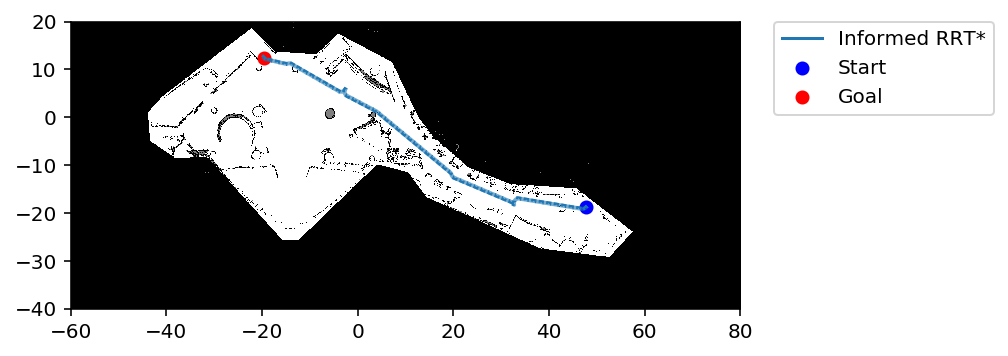

In [21]:
results_folder_prefix = "mod-tests-atc1/"
from trajectory import visualize
visualize('{}/combined.json'.format(results_folder_prefix))

Plot planner statistics:

Visualizing atc-scenario1/combined.json...


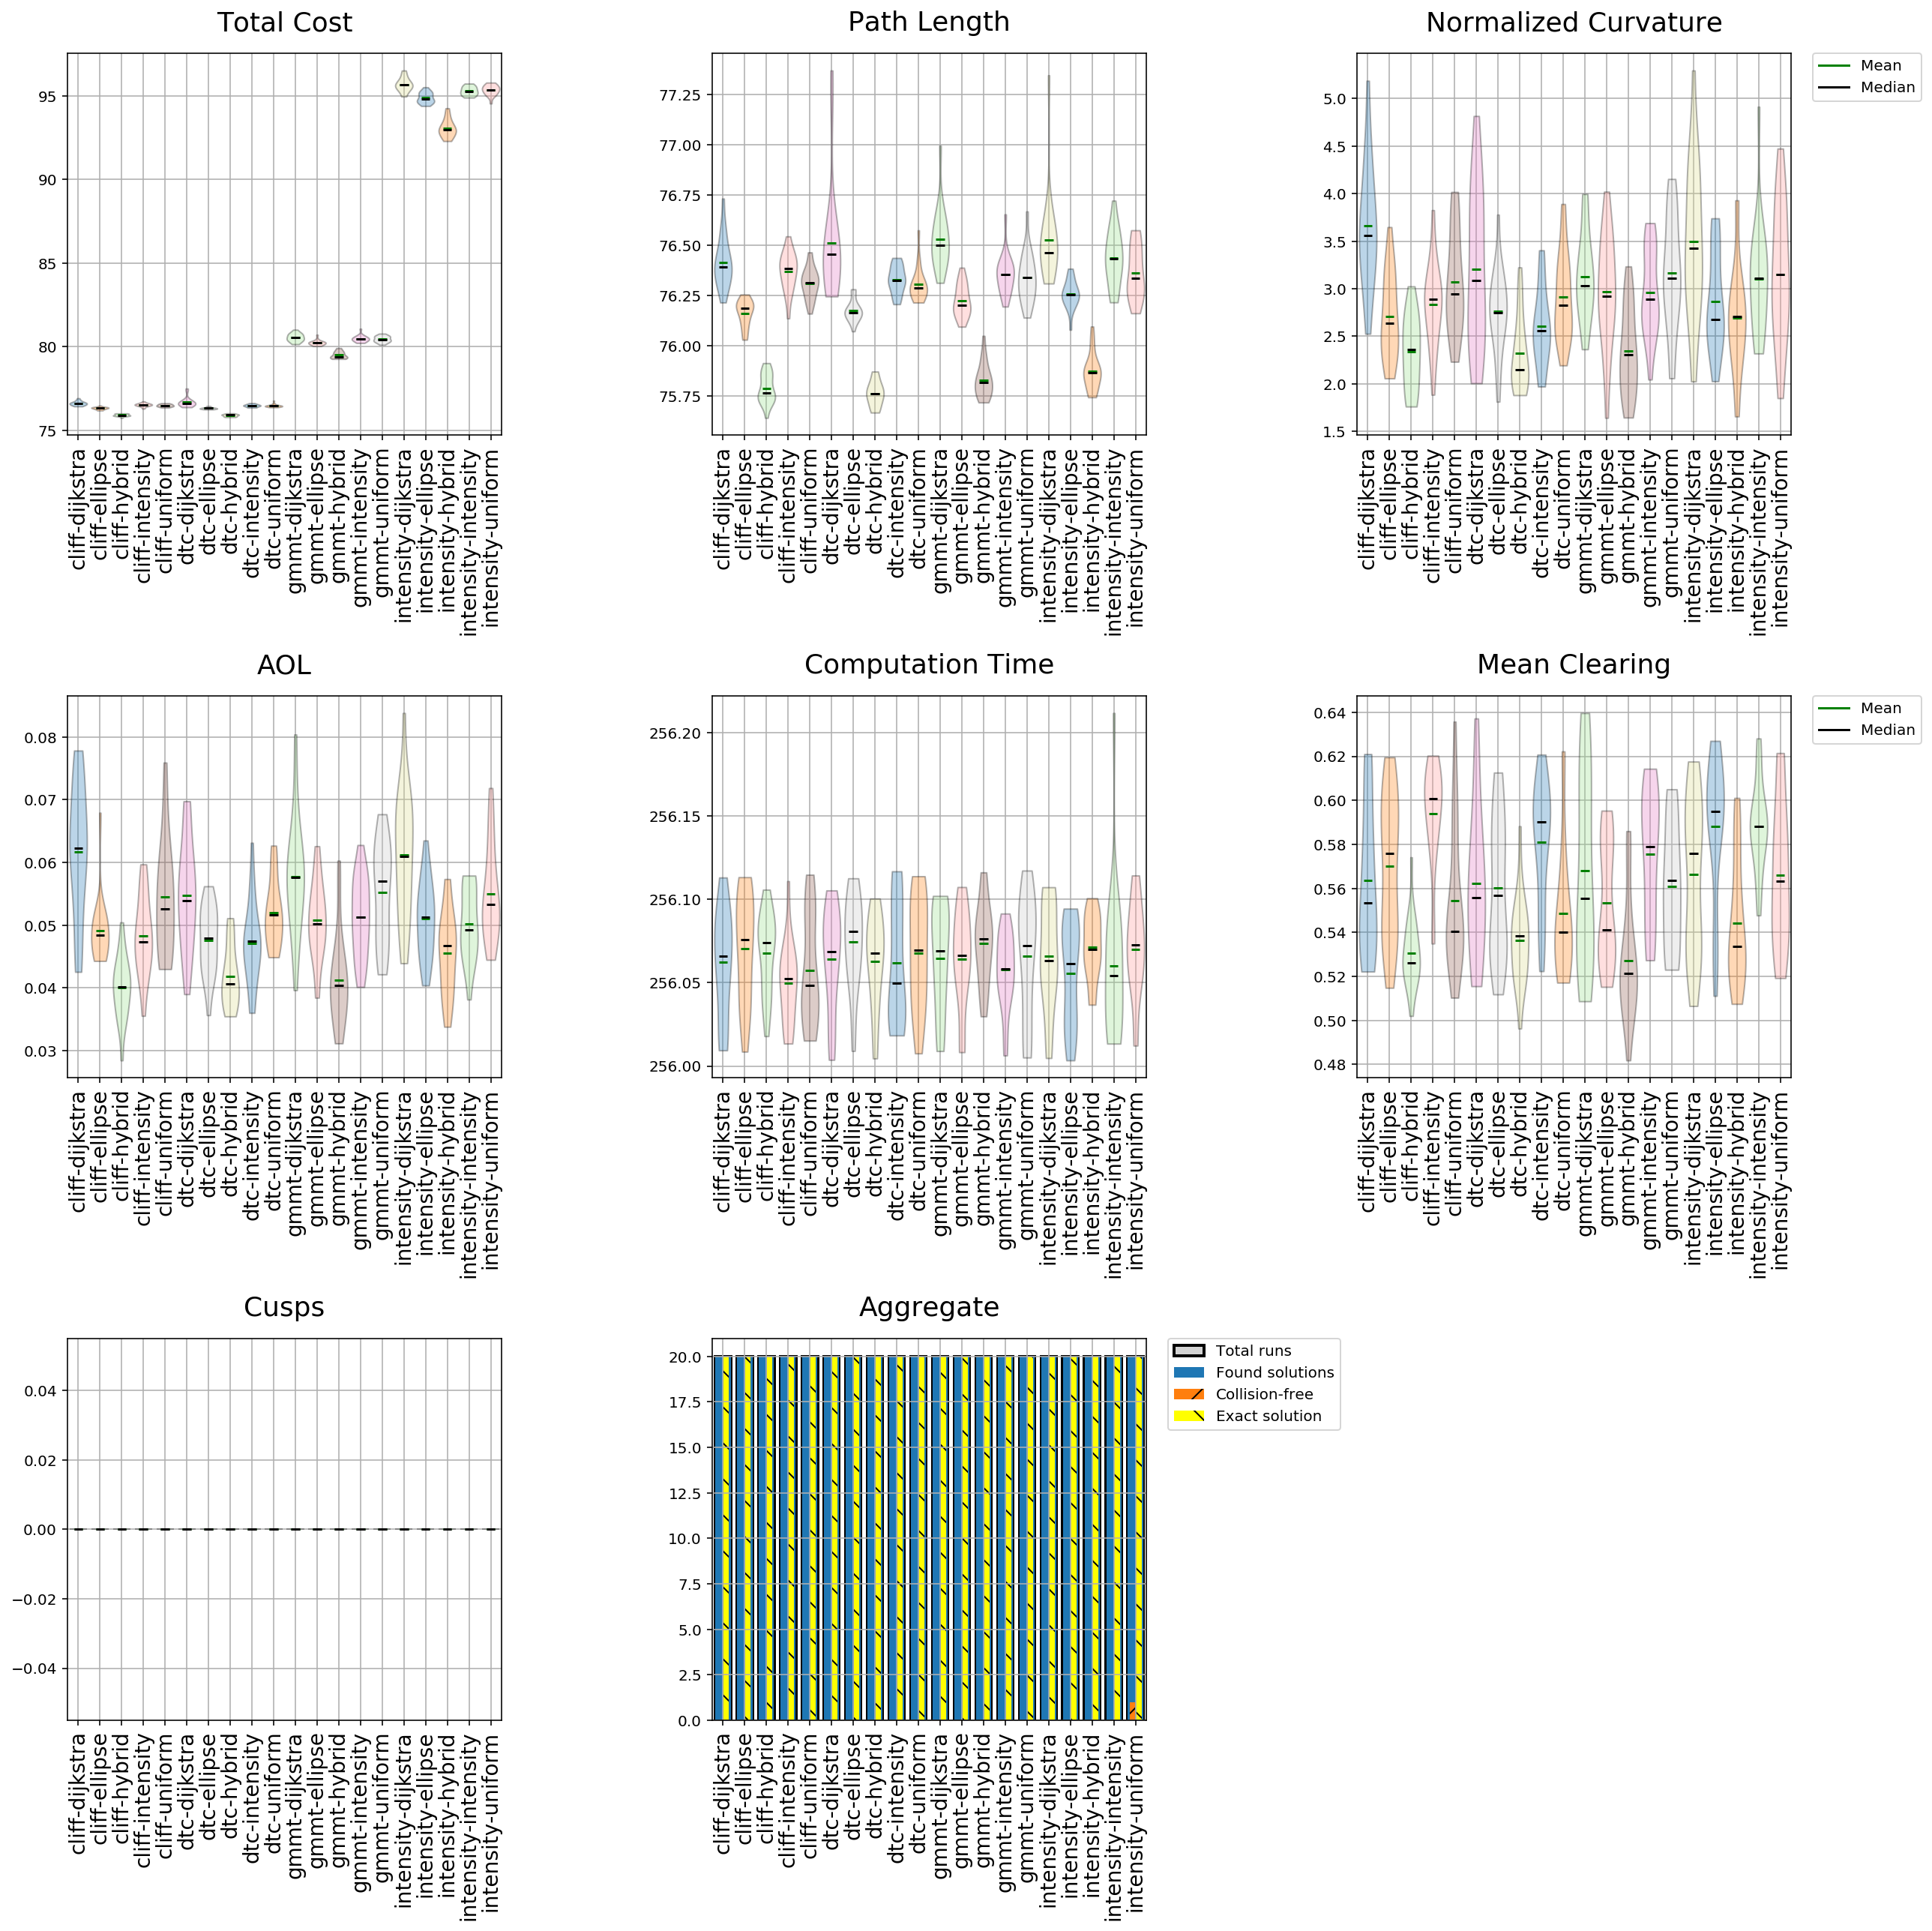

In [3]:
from plot_stats import plot_planner_stats
plot_planner_stats('{}/combined.json'.format(results_folder_prefix), num_colors=8, ticks_rotation=90)